In [1]:
import os
import numpy as np
import json
from pathlib import Path
import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import random


# Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Input path (double nested SODA-A, sorry my bad)
DATASET_PATH = '/content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A'

# Output path (where we'll save processed data)
OUTPUT_PATH = '/content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/SODA-A-Processed'

#  paths
print("Verifying paths...")
print(f"Dataset path exists: {os.path.exists(DATASET_PATH)}")
if os.path.exists(DATASET_PATH):
    print("Input contents:", os.listdir(DATASET_PATH))


Mounted at /content/drive
Verifying paths...
Dataset path exists: True
Input contents: ['Images', 'Annotations', 'SODA-A-Processed']


In [2]:
!pip install albumentations opencv-python
!pip install torch torchvision albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
from torchvision.transforms import Compose, Resize, Normalize
from torch.utils.data import  RandomSampler, SequentialSampler

In [4]:
# Verify the  path ...
print("Checking dataset path...")
print(f"Images path exists: {os.path.exists(os.path.join(DATASET_PATH, 'Images'))}")
print(f"Annotations path exists: {os.path.exists(os.path.join(DATASET_PATH, 'Annotations'))}")

Checking dataset path...
Images path exists: True
Annotations path exists: True


In [5]:
class SODADataset(Dataset):
    """Optimized Dataset class for SODA-A aerial imagery"""
    def __init__(self, root_dir, split='train', image_size=(416, 416), is_training=True):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.is_training = is_training

        # Define paths AGAIN
        self.images_dir = self.root_dir / "Images" / split
        self.annotations_dir = self.root_dir / "Annotations" / split

        # Verify paths exist Again...
        print(f"Checking paths for {split}:")
        print(f"Images directory: {self.images_dir}")
        print(f"Images directory exists: {self.images_dir.exists()}")
        print(f"Annotations directory: {self.annotations_dir}")
        print(f"Annotations directory exists: {self.annotations_dir.exists()}")

        if not self.images_dir.exists() or not any(self.images_dir.iterdir()):
            raise FileNotFoundError(f"Image directory for split '{split}' not found or empty: {self.images_dir}")
        if not self.annotations_dir.exists() or not any(self.annotations_dir.iterdir()):
            raise FileNotFoundError(f"Annotation directory for split '{split}' not found or empty: {self.annotations_dir}")

        #  initialization code
        self.image_files = sorted(list(self.images_dir.glob("*.jpg")))
        self.annotations_cache = {}
        print(f"Loading {split} annotations...")
        for ann_file in self.annotations_dir.glob("*.json"):
            with open(ann_file, 'r') as f:
                self.annotations_cache[ann_file.stem] = json.load(f)

        self.class_map = {
            'airplane': 0, 'helicopter': 1, 'small vehicle': 2,
            'large vehicle': 3, 'ship': 4, 'container': 5,
            'storage-tank': 6, 'swimming-pool': 7, 'windmill': 8
        }

        self.transforms = self._get_transforms()
        print(f"Found {len(self.image_files)} images in {split} split")

    def __len__(self):
        """Return the total number of images in the dataset"""
        return len(self.image_files)

    # class methods
    def _get_transforms(self):
        if self.is_training:
            return A.Compose([
                A.Resize(height=self.image_size[0], width=self.image_size[1]),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
        else:
            return A.Compose([
                A.Resize(height=self.image_size[0], width=self.image_size[1]),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
# to check GPU
def check_gpu():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
    return device


In [7]:
#  create_data_loaders function with smaller batch size
def create_data_loaders(dataset_path, batch_size=16, num_workers=2):
    """Create optimized data loaders"""
    train_dataset = SODADataset(
        root_dir=dataset_path,
        split='train',
        image_size=(416, 416),
        is_training=True
    )

    val_dataset = SODADataset(
        root_dir=dataset_path,
        split='val',
        image_size=(416, 416),
        is_training=False
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        persistent_workers=True
    )

    return train_loader, val_loader


In [8]:
def collate_fn(batch):
    """Collate function to handle variable number of objects per image"""
    images = []
    boxes = []
    labels = []
    image_ids = []

    for b in batch:
        images.append(b['image'])
        boxes.append(b['boxes'])
        labels.append(b['labels'])
        image_ids.append(b['image_id'])

    # Stack images into a single tensor
    images = torch.stack(images)

    return {
        'images': images,
        'boxes': boxes,
        'labels': labels,
        'image_ids': image_ids
    }



In [9]:
def load_dataset(dataset_path, split='train'):
    try:
        print(f"\nLoading {split} dataset...")
        dataset = SODADataset(
            root_dir=dataset_path,
            split=split,
            image_size=(1024, 1024),  # Increased for small objects
            is_training=(split == 'train')
        )
        print(f"{split} dataset loaded successfully with {len(dataset)} images")
        return dataset
    except Exception as e:
        print(f"Error loading {split} dataset: {str(e)}")
        raise

# Load datasets
train_dataset = load_dataset(DATASET_PATH, 'train')
val_dataset = load_dataset(DATASET_PATH, 'val')


Loading train dataset...
Checking paths for train:
Images directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Images/train
Images directory exists: True
Annotations directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Annotations/train
Annotations directory exists: True
Loading train annotations...
Found 1067 images in train split
train dataset loaded successfully with 1067 images

Loading val dataset...
Checking paths for val:
Images directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Images/val
Images directory exists: True
Annotations directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Annotations/val
Annotations directory exists: True
Loading val annotations...
Found 576 images in val split
val dataset loaded successfully with 576 images


In [10]:
train_dataset = SODADataset(DATASET_PATH, split='train')
val_dataset = SODADataset(DATASET_PATH, split='val')

Checking paths for train:
Images directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Images/train
Images directory exists: True
Annotations directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Annotations/train
Annotations directory exists: True
Loading train annotations...
Found 1067 images in train split
Checking paths for val:
Images directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Images/val
Images directory exists: True
Annotations directory: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/Annotations/val
Annotations directory exists: True
Loading val annotations...
Found 576 images in val split


In [11]:
class SODAPreprocessor:
    def __init__(self, dataset_path, output_path, image_size=(416, 416)):
        self.dataset_path = Path(dataset_path)
        self.output_path = Path(output_path)
        self.image_size = image_size

        # Create output directories
        for split in ['train', 'val']:
            (self.output_path / split / 'images').mkdir(parents=True, exist_ok=True)
            (self.output_path / split / 'annotations').mkdir(parents=True, exist_ok=True)


        self.transforms = A.Compose([
            A.Resize(height=image_size[0], width=image_size[1]),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ], bbox_params={'format': 'coco', 'min_area': 0, 'min_visibility': 0, 'label_fields': ['labels']})

    def process_split(self, split):
        images_dir = self.dataset_path / "Images" / split
        annotations_dir = self.dataset_path / "Annotations" / split

        print(f"\nProcessing {split} split...")
        image_files = sorted(list(images_dir.glob("*.jpg")))

        stats = {'processed': 0, 'skipped': 0, 'total_boxes': 0, 'valid_boxes': 0}

        for img_path in tqdm(image_files, desc=f"Processing {split}"):
            try:
                # Load image
                image = cv2.imread(str(img_path))
                if image is None:
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Get original dimensions
                img_height, img_width = image.shape[:2]

                # Load annotation
                ann_path = annotations_dir / f"{img_path.stem}.json"
                with open(ann_path, 'r') as f:
                    ann_data = json.load(f)

                # Process annotations
                boxes = []
                labels = []
                valid_annotations = []

                for ann in ann_data['annotations']:
                    stats['total_boxes'] += 1

                    if 'poly' in ann:
                        # Convert polygon to bbox
                        poly = np.array(ann['poly']).reshape(-1, 2)
                        x1, y1 = np.min(poly, axis=0)
                        x2, y2 = np.max(poly, axis=0)
                        bbox = [x1, y1, x2 - x1, y2 - y1]  # Convert to COCO format
                    else:
                        bbox = ann.get('bbox', None)
                        if bbox is None:
                            continue

                    # Validate bbox
                    x, y, w, h = bbox
                    if w <= 0 or h <= 0:
                        continue

                    # Clip to image boundaries
                    x = max(0, min(x, img_width))
                    y = max(0, min(y, img_height))
                    w = min(w, img_width - x)
                    h = min(h, img_height - y)

                    if w > 0 and h > 0:
                        boxes.append([x, y, w, h])
                        labels.append(ann['category_id'])
                        valid_annotations.append(ann)
                        stats['valid_boxes'] += 1

                if not boxes:
                    stats['skipped'] += 1
                    continue

                # Apply transforms
                transformed = self.transforms(
                    image=image,
                    bboxes=boxes,
                    labels=labels
                )

                # Save processed image
                output_img_path = self.output_path / split / 'images' / img_path.name
                processed_image = (transformed['image'] * 255).astype(np.uint8)
                cv2.imwrite(str(output_img_path), cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

                # Save processed annotations
                processed_annotations = {
                    'images': {
                        'file_name': img_path.name,
                        'height': self.image_size[0],
                        'width': self.image_size[1],
                        'id': ann_data['images'].get('id', img_path.stem)
                    },
                    'annotations': []
                }

                # Convert transformed boxes back to annotations
                for (x, y, w, h), label in zip(transformed['bboxes'], transformed['labels']):
                    processed_annotations['annotations'].append({
                        'bbox': [float(x), float(y), float(w), float(h)],
                        'category_id': int(label),
                        'image_id': ann_data['images'].get('id', img_path.stem)
                    })

                if 'categories' in ann_data:
                    processed_annotations['categories'] = ann_data['categories']

                output_ann_path = self.output_path / split / 'annotations' / f"{img_path.stem}.json"
                with open(output_ann_path, 'w') as f:
                    json.dump(processed_annotations, f, indent=2)

                stats['processed'] += 1

            except Exception as e:
                print(f"\nError processing {img_path}: {str(e)}")
                stats['skipped'] += 1
                continue

        print(f"\nProcessing statistics for {split} split:")
        print(f"Successfully processed: {stats['processed']} images")
        print(f"Skipped images: {stats['skipped']}")
        print(f"Total boxes: {stats['total_boxes']}")
        print(f"Valid boxes: {stats['valid_boxes']}")

    def process_dataset(self):
        for split in ['train', 'val']:
            self.process_split(split)

# Add verification function
def verify_processed_dataset(processed_path):
    """Verify the processed dataset"""
    for split in ['train', 'val']:
        img_path = Path(processed_path) / split / 'images'
        ann_path = Path(processed_path) / split / 'annotations'

        n_images = len(list(img_path.glob('*.jpg')))
        n_annotations = len(list(ann_path.glob('*.json')))

        print(f"\n{split} split verification:")
        print(f"Images found: {n_images}")
        print(f"Annotations found: {n_annotations}")

        if n_annotations > 0:
            # Check a random annotation file
            random_ann = random.choice(list(ann_path.glob('*.json')))
            with open(random_ann, 'r') as f:
                ann_data = json.load(f)
            print(f"\nSample annotation check ({random_ann.name}):")
            print(f"Number of annotations: {len(ann_data['annotations'])}")
            if len(ann_data['annotations']) > 0:
                print("Sample bbox:", ann_data['annotations'][0]['bbox'])

In [12]:

# Run preprocessing
if __name__ == "__main__":
    DATASET_PATH = '/content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A'
    OUTPUT_PATH = '/content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/SODA-A-Processed'

    print(f"Original dataset path: {DATASET_PATH}")
    print(f"Output path: {OUTPUT_PATH}")

    preprocessor = SODAPreprocessor(DATASET_PATH, OUTPUT_PATH)
    preprocessor.process_dataset()

    # Verify the processing
    for split in ['train', 'val']:
        img_path = Path(OUTPUT_PATH) / split / 'images'
        ann_path = Path(OUTPUT_PATH) / split / 'annotations'

        if img_path.exists() and ann_path.exists():
            n_images = len(list(img_path.glob('*.jpg')))
            n_annotations = len(list(ann_path.glob('*.json')))
            print(f"\n{split} split:")
            print(f"Images processed: {n_images}")
            print(f"Annotations processed: {n_annotations}")

            # to verify random annotation file
            if n_annotations > 0:
                random_ann = random.choice(list(ann_path.glob('*.json')))
                with open(random_ann, 'r') as f:
                    ann_data = json.load(f)
                print(f"\nSample annotation structure for {random_ann.name}:")
                print(f"Number of annotations: {len(ann_data['annotations'])}")
                print(f"Image dimensions: {ann_data['images']['height']}x{ann_data['images']['width']}")

Original dataset path: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A
Output path: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/SODA-A-Processed

Processing train split...


Processing train: 100%|██████████| 1067/1067 [07:16<00:00,  2.45it/s]



Processing statistics for train split:
Successfully processed: 1067 images
Skipped images: 0
Total boxes: 346913
Valid boxes: 346913

Processing val split...


Processing val: 100%|██████████| 576/576 [03:21<00:00,  2.85it/s]



Processing statistics for val split:
Successfully processed: 576 images
Skipped images: 0
Total boxes: 233287
Valid boxes: 233287

train split:
Images processed: 1067
Annotations processed: 1067

Sample annotation structure for 01318.json:
Number of annotations: 668
Image dimensions: 416x416

val split:
Images processed: 576
Annotations processed: 576

Sample annotation structure for 01894.json:
Number of annotations: 49
Image dimensions: 416x416



Analyzing train split...


100%|██████████| 1067/1067 [00:08<00:00, 119.25it/s]



Analyzing val split...


100%|██████████| 576/576 [00:04<00:00, 123.19it/s]



Train Split Analysis:


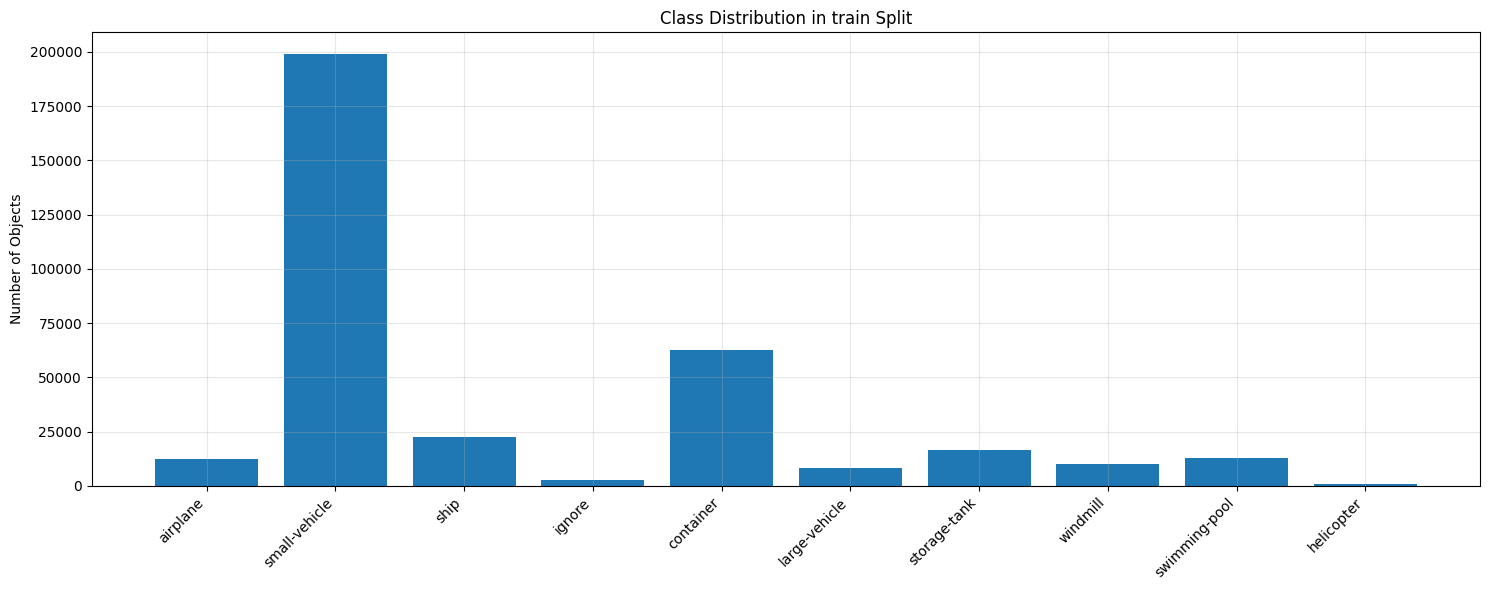


Class counts:
small-vehicle: 199045
container: 62684
ship: 22283
storage-tank: 16488
swimming-pool: 12615
airplane: 12313
windmill: 9946
large-vehicle: 8234
ignore: 2685
helicopter: 620


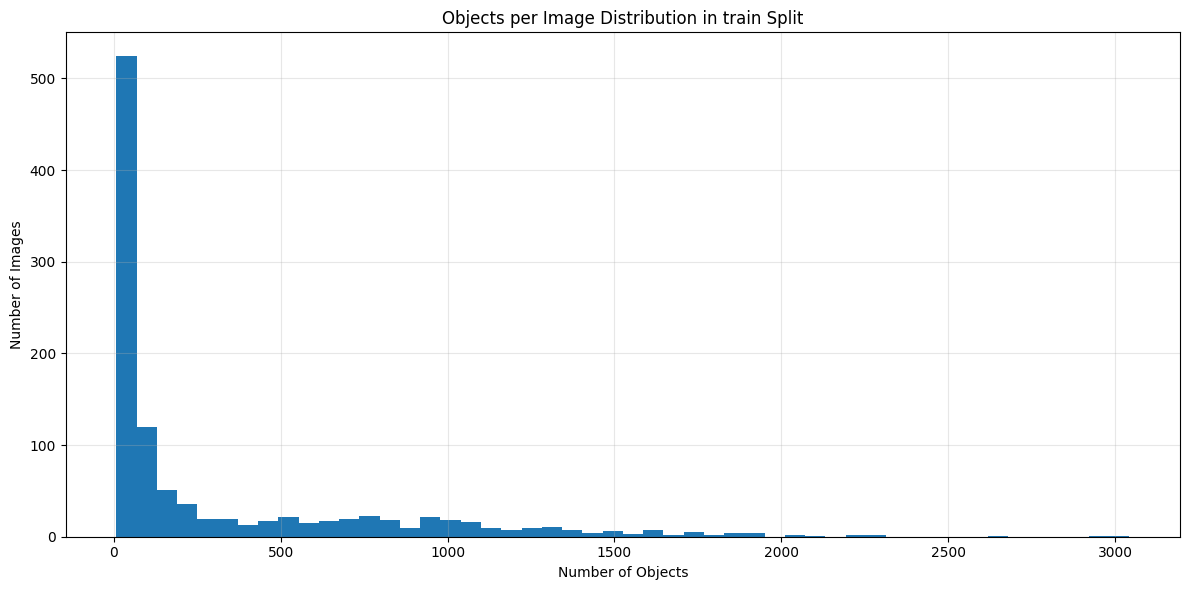


Objects per image statistics:
Mean: 325.13
Median: 73.00
Min: 8
Max: 3042


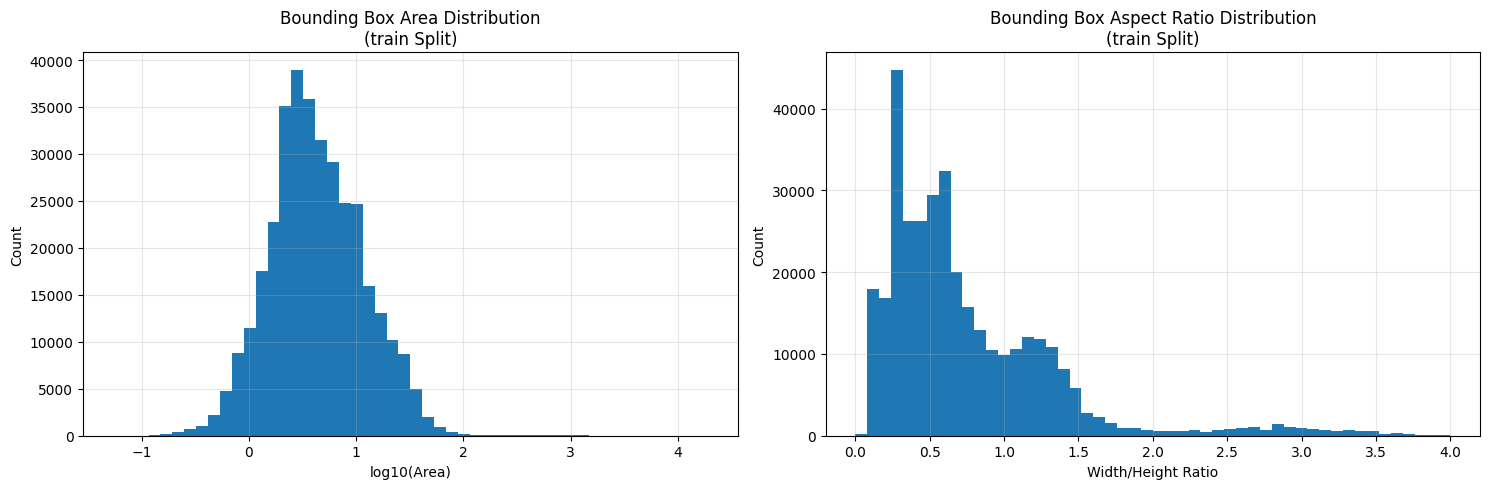

<ipython-input-13-ea1cc37ccd3c>:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(split_stats['class_bbox_areas'].keys()),


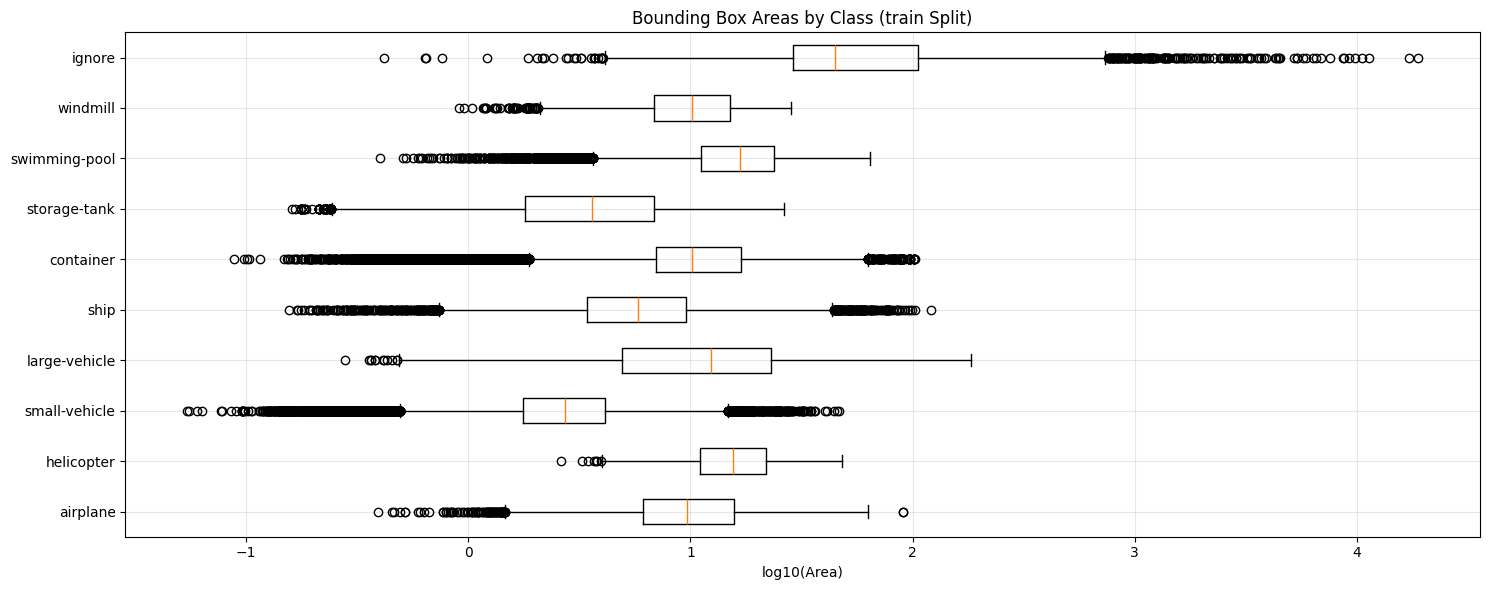


Validation Split Analysis:


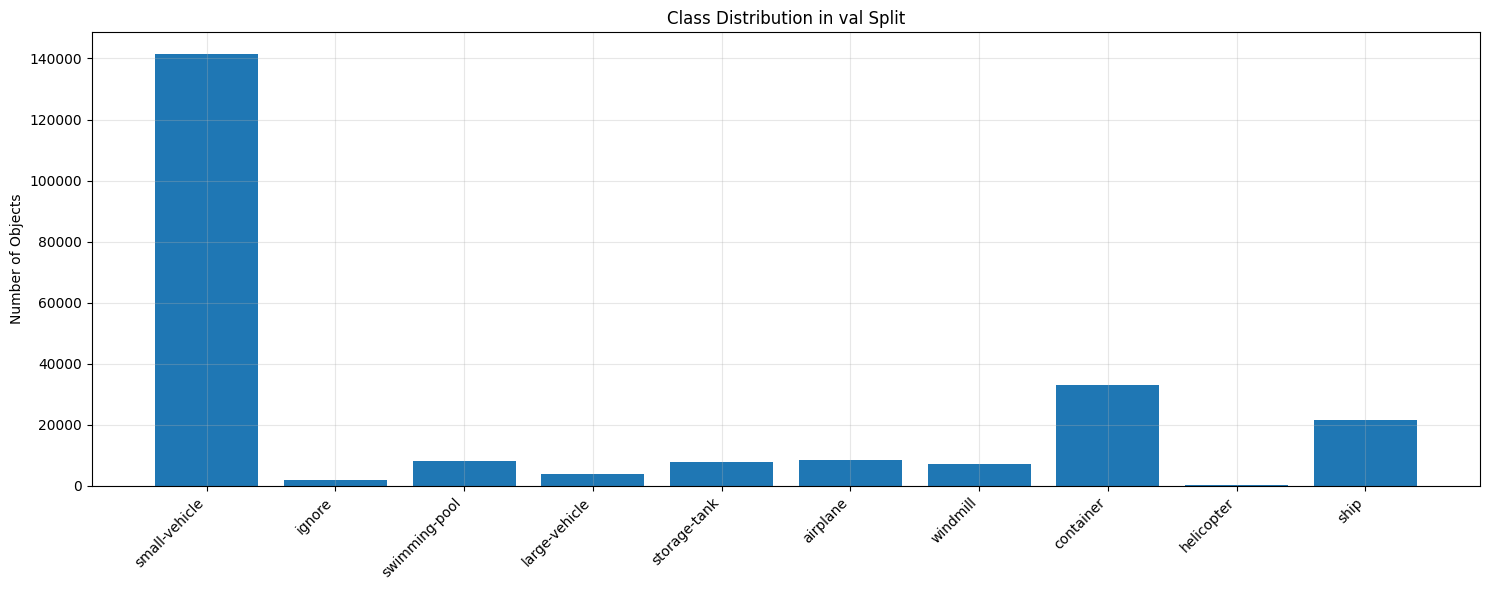


Class counts:
small-vehicle: 141492
container: 32963
ship: 21666
airplane: 8562
swimming-pool: 7975
storage-tank: 7700
windmill: 7067
large-vehicle: 3750
ignore: 1848
helicopter: 264


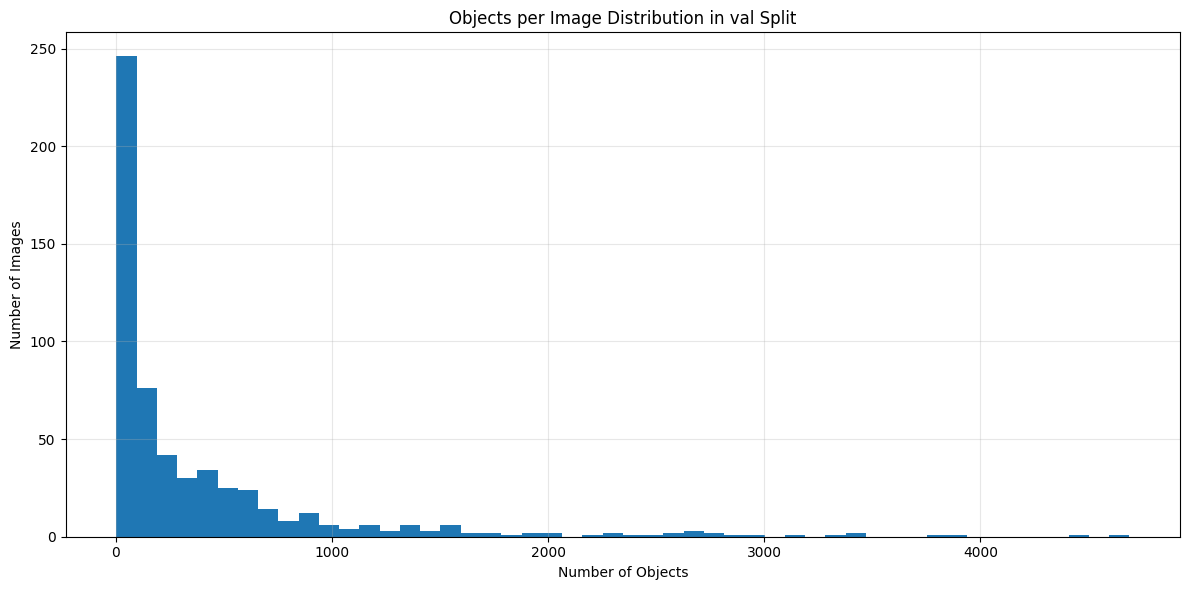


Objects per image statistics:
Mean: 405.01
Median: 133.50
Min: 2
Max: 4689


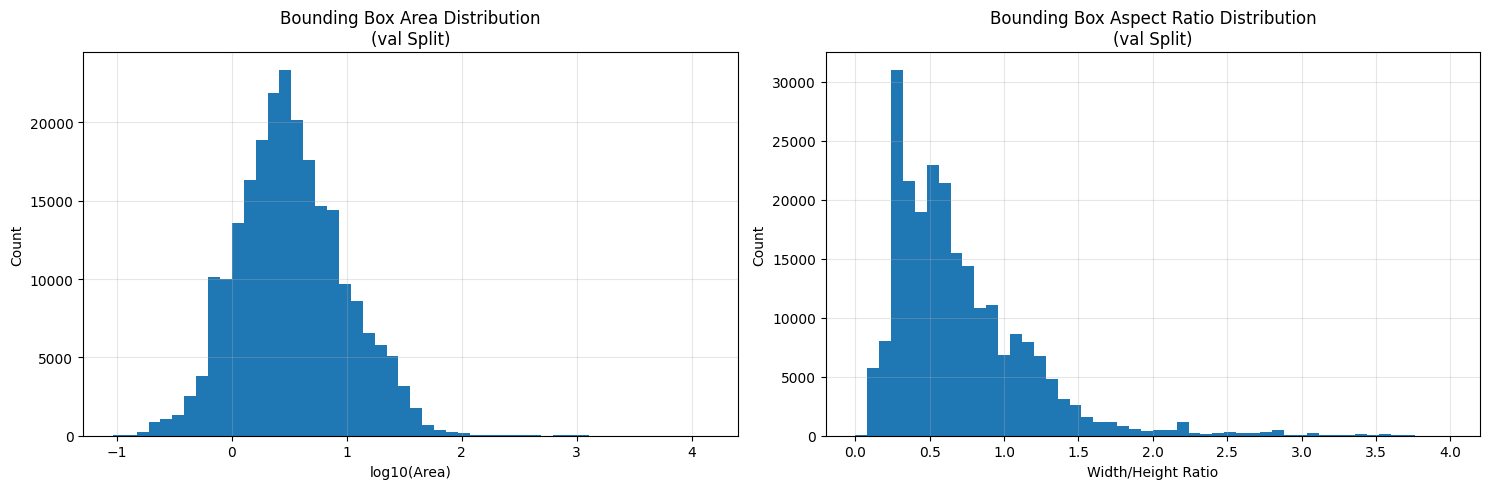

<ipython-input-13-ea1cc37ccd3c>:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=list(split_stats['class_bbox_areas'].keys()),


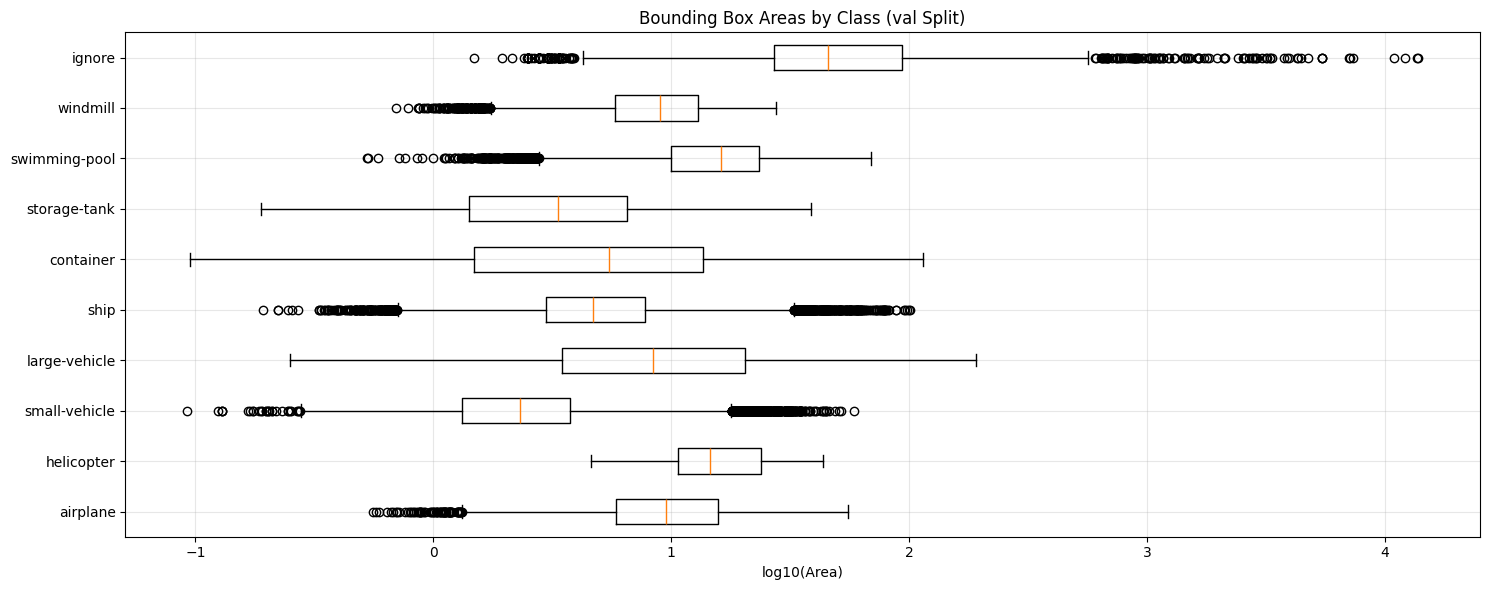

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
from collections import Counter
import seaborn as sns
from tqdm import tqdm

class SODAExplorer:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.class_names = {
            0: 'airplane',
            1: 'helicopter',
            2: 'small-vehicle',
            3: 'large-vehicle',
            4: 'ship',
            5: 'container',
            6: 'storage-tank',
            7: 'swimming-pool',
            8: 'windmill',
            9: 'ignore'
        }

    def analyze_split(self, split='train'):
        print(f"\nAnalyzing {split} split...")
        annotations_dir = self.dataset_path / split / 'annotations'

        # Initialize counters
        class_counts = Counter()
        objects_per_image = []
        bbox_areas = []
        bbox_aspects = []
        class_bbox_areas = {cls: [] for cls in self.class_names.values()}

        # Analyze annotation file
        for ann_file in tqdm(list(annotations_dir.glob('*.json'))):
            with open(ann_file, 'r') as f:
                data = json.load(f)

            # Count objects per image
            n_objects = len(data['annotations'])
            objects_per_image.append(n_objects)

            # Analyze each annotation
            for ann in data['annotations']:
                category_id = ann['category_id']
                class_counts[self.class_names[category_id]] += 1

                # Calculate bbox area and aspect ratio
                bbox = ann['bbox']
                area = bbox[2] * bbox[3]  # width * height
                aspect = bbox[2] / bbox[3] if bbox[3] != 0 else 0

                bbox_areas.append(area)
                bbox_aspects.append(aspect)
                class_bbox_areas[self.class_names[category_id]].append(area)

        return {
            'class_counts': class_counts,
            'objects_per_image': objects_per_image,
            'bbox_areas': bbox_areas,
            'bbox_aspects': bbox_aspects,
            'class_bbox_areas': class_bbox_areas
        }

    def plot_class_distribution(self, split_stats, split='train'):
        plt.figure(figsize=(15, 6))
        counts = split_stats['class_counts']
        plt.bar(counts.keys(), counts.values())
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Class Distribution in {split} Split')
        plt.ylabel('Number of Objects')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print exact counts
        print("\nClass counts:")
        for cls, count in counts.most_common():
            print(f"{cls}: {count}")

    def plot_objects_per_image(self, split_stats, split='train'):
        plt.figure(figsize=(12, 6))
        plt.hist(split_stats['objects_per_image'], bins=50)
        plt.title(f'Objects per Image Distribution in {split} Split')
        plt.xlabel('Number of Objects')
        plt.ylabel('Number of Images')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print stats
        objects = split_stats['objects_per_image']
        print(f"\nObjects per image statistics:")
        print(f"Mean: {np.mean(objects):.2f}")
        print(f"Median: {np.median(objects):.2f}")
        print(f"Min: {np.min(objects)}")
        print(f"Max: {np.max(objects)}")

    def plot_size_distributions(self, split_stats, split='train'):
        # Overall bbox area distribution
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        plt.hist(np.log10(split_stats['bbox_areas']), bins=50)
        plt.title(f'Bounding Box Area Distribution\n({split} Split)')
        plt.xlabel('log10(Area)')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)

        plt.subplot(122)
        plt.hist(split_stats['bbox_aspects'], bins=50, range=(0, 4))
        plt.title(f'Bounding Box Aspect Ratio Distribution\n({split} Split)')
        plt.xlabel('Width/Height Ratio')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_class_sizes(self, split_stats, split='train'):
        plt.figure(figsize=(15, 6))
        data = []
        labels = []

        for cls, areas in split_stats['class_bbox_areas'].items():
            if areas:  # if so to only include classes that have instances
                data.append(np.log10(areas))
                labels.extend([cls] * len(areas))

        plt.boxplot(data, labels=list(split_stats['class_bbox_areas'].keys()),
                   vert=False)
        plt.title(f'Bounding Box Areas by Class ({split} Split)')
        plt.xlabel('log10(Area)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Usage
PROCESSED_PATH = '/content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/SODA-A-Processed'
explorer = SODAExplorer(PROCESSED_PATH)

# Analyze both splits
train_stats = explorer.analyze_split('train')
val_stats = explorer.analyze_split('val')

# Plot distributions for train split
print("\nTrain Split Analysis:")
explorer.plot_class_distribution(train_stats, 'train')
explorer.plot_objects_per_image(train_stats, 'train')
explorer.plot_size_distributions(train_stats, 'train')
explorer.plot_class_sizes(train_stats, 'train')

# Plot distributions for validation split
print("\nValidation Split Analysis:")
explorer.plot_class_distribution(val_stats, 'val')
explorer.plot_objects_per_image(val_stats, 'val')
explorer.plot_size_distributions(val_stats, 'val')
explorer.plot_class_sizes(val_stats, 'val')

In [14]:
import matplotlib.pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np


Selected image: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/SODA-A-Processed/train/images/00548.jpg
Looking for annotation file: /content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/SODA-A-Processed/train/annotations/00548.json

Image shape: (416, 416, 3)
Number of annotations: 30
Categories found: {'windmill', 'ignore'}


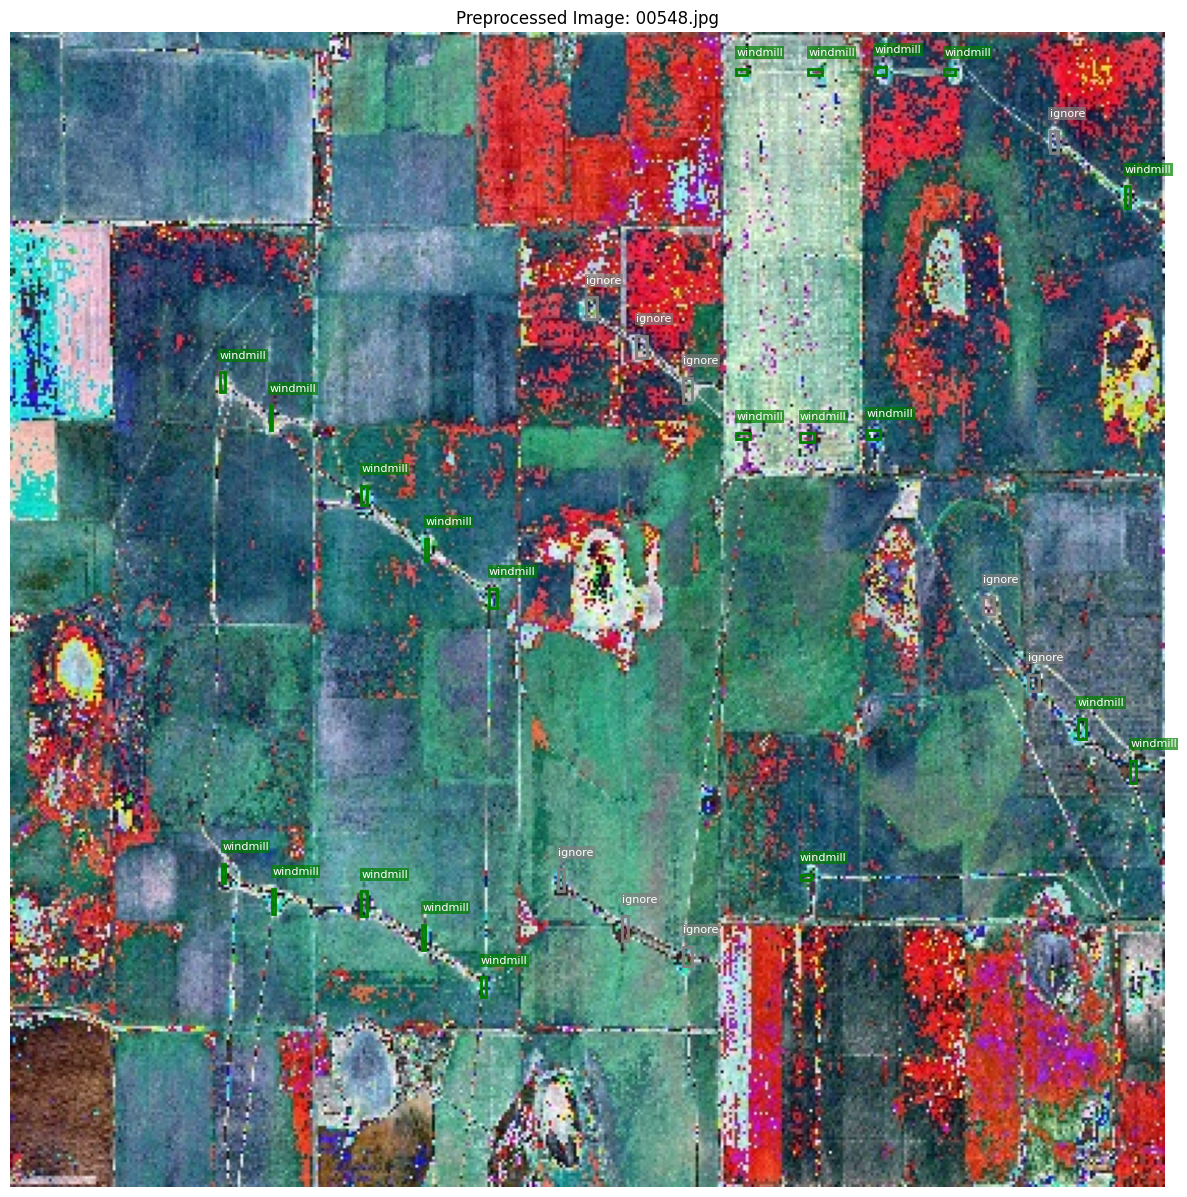

In [15]:

def visualize_preprocessed_image(processed_path, split='train', random_img=True, img_idx=0):
    """
    Visualize a preprocessed image with its annotations from the SODA dataset.
    """
    processed_path = Path(processed_path)
    images_dir = processed_path / split / 'images'
    annotations_dir = processed_path / split / 'annotations'

    # Get list of images
    image_files = sorted(list(images_dir.glob("*.jpg")))
    if not image_files:
        raise FileNotFoundError(f"No images found in {images_dir}")

    # Select image
    img_path = random.choice(image_files) if random_img else image_files[img_idx]
    print(f"Selected image: {img_path}")

    # Load image
    image = cv2.imread(str(img_path))
    if image is None:
        raise ValueError(f"Failed to load image: {img_path}")

    # Convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # loading corresponding annotation
    ann_path = annotations_dir / f"{img_path.stem}.json"
    print(f"Looking for annotation file: {ann_path}")

    with open(ann_path, 'r') as f:
        ann_data = json.load(f)

    # Create figure
    plt.figure(figsize=(15, 15))
    plt.imshow(image)

    # Define colors for different classes
    colors = {
        0: '#FF0000',  # airplane (red)
        1: '#00FF00',  # helicopter (green)
        2: '#0000FF',  # small-vehicle (blue)
        3: '#FFFF00',  # large-vehicle (yellow)
        4: '#FF00FF',  # ship (magenta)
        5: '#00FFFF',  # container (cyan)
        6: '#FFA500',  # storage-tank (orange)
        7: '#800080',  # swimming-pool (purple)
        8: '#008000',  # windmill (dark green)
        9: '#808080'   # ignore (gray)
    }

    class_names = {
        0: 'airplane',
        1: 'helicopter',
        2: 'small-vehicle',
        3: 'large-vehicle',
        4: 'ship',
        5: 'container',
        6: 'storage-tank',
        7: 'swimming-pool',
        8: 'windmill',
        9: 'ignore'
    }

    # Draw bounding boxes
    for ann in ann_data['annotations']:
        bbox = ann['bbox']
        category_id = ann['category_id']

        # Get color and class name
        color = colors.get(category_id, '#FFFFFF')
        class_name = class_names.get(category_id, 'unknown')

        # Extract coordinates
        x, y, w, h = map(int, bbox)

        # Draw rectangle
        rect = plt.Rectangle((x, y), w, h,
                           fill=False,
                           edgecolor=color,
                           linewidth=2)
        plt.gca().add_patch(rect)

        # Add label with background
        plt.text(x, y-5, class_name,
                color='white',
                fontsize=8,
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1))

    plt.title(f"Preprocessed Image: {img_path.name}")
    plt.axis('off')

    # Print statistics
    print(f"\nImage shape: {image.shape}")
    print(f"Number of annotations: {len(ann_data['annotations'])}")
    print("Categories found:", set(class_names[ann['category_id']] for ann in ann_data['annotations']))

    plt.show()

# Example usage
PROCESSED_PATH = '/content/drive/My Drive/NORTHEASTERN/subject/MasterP/Assignments/project/dataset/SODA-A/SODA-A-Processed'
visualize_preprocessed_image(PROCESSED_PATH, split='train', random_img=True)